<center><h1>Tahakom Training Week 1: Transformers for Vision</h1></center>

<center><h2>Day 2:  Vision Transformer</h2> </center>


In this tutorial, we will take a closer look at a recent new trend: Transformers for Computer Vision.
Since [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy) successfully applied a Transformer on a variety of image recognition benchmarks, there have been an incredible amount of follow-up works showing that CNNs might not be optimal architecture for Computer Vision anymore.
But how do Vision Transformers work exactly, and what benefits and drawbacks do they offer in contrast to CNNs?
We will answer these questions by implementing a Vision Transformer ourselves, and train it on the popular, small dataset CIFAR10.
We will compare these results to popular convolutional architectures such as Inception, ResNet and DenseNet.
This notebook is part of a lecture series on Deep Learning at the University of Amsterdam.
The full list of tutorials can be found at https://uvadlc-notebooks.rtfd.io.

Research Paper: [An image is worth 16x16 words: Transformers for image recognition at scale](https://openreview.net/pdf?id=YicbFdNTTy).


Content:
1. Explore the different components of Vision Transformer
- Image Patches
- Embedding Patches
- [Class] Token
- Positional Information
- Self-Attention
- Multi-Head Self-Attention
- Multi-Layer Perceptron
- Transformer Encoder
- Classification Head
- Vision Transformer
2. Build Vision Transformer
3. <s>Training</s> Finetuning a Vision Transformer
4. Visualization

In [2]:
# Check if has GPU Enabled
!nvidia-smi

Sun May  5 17:41:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              27W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Explore the different components of Vision Transformer
![ViT](https://upload.wikimedia.org/wikipedia/commons/3/3e/Vision_Transformer.gif)

Inspired by the Transformer scaling successes in NLP, we experiment with applying a standard Transformer directly to images, with the fewest possible modifications. To do so, **we split an image into patches and provide the sequence of linear embeddings of these patches as an input to a Transformer**. Image patches are treated the same way as tokens (words) in an NLP application. We train the model on image classification in supervised fashion.  <br><sub>1 Introduction<sub>

In model design we follow the original Transformer (Vaswani et al., 2017) as closely as possible.
An advantage of this intentionally simple setup is that scalable NLP Transformer architectures – and
their efficient implementations – can be used almost out of the box. <br><sub>3 Method<sub>


## Model Configuration

<img src='https://raw.githubusercontent.com/IVUL-KAUST/TahakomTraining/main/figs/img1.png' />



We will walk through the components of Vision Transformer:
- Image Patches
-Embedding Patches
-[Class] Token
-Positional Information
-Self-Attention
-Multi-Head Self-Attention
-Multi-Layer Perceptron
-Transformer Encoder
-Classification Head
-Vision Transformer

## Image To Patches
<img src='https://raw.githubusercontent.com/IVUL-KAUST/TahakomTraining/main/figs/img2.png' />

In [36]:
# Unit test on patching an image

import urllib.request

urllib.request.urlretrieve(
  'https://drive.google.com/uc?id=1h6ODFoGIMLgLGOiTdWz7CKWdJPOjUiu8',
   "car.png")

# read image and resize to 128
image = Image.open('car.png').resize((128, 128))

# convert to numpy array
x = np.array(image)


# An Image Is Worth 16x16 Words
P = 16   # patch size
C = 3    # number of channels (RGB)

# split image into patches using numpy
patches = x.reshape(x.shape[0]//P, P, x.shape[1]//P, P, C).swapaxes(1, 2).reshape(-1, P, P, C)

# flatten patches
x_p = np.reshape(patches, (-1, P * P * C))

# get number of patches
N = x_p.shape[0]

print('Image shape: ', x.shape)  # width, height, channel
print('Number of patches: {} with resolution ({}, {})'.format(N, P, P))
print('Patches shape: ', patches.shape)
print('Flattened patches shape: ', x_p.shape)

Image shape:  (128, 128, 3)
Number of patches: 64 with resolution (16, 16)
Patches shape:  (64, 16, 16, 3)
Flattened patches shape:  (64, 768)


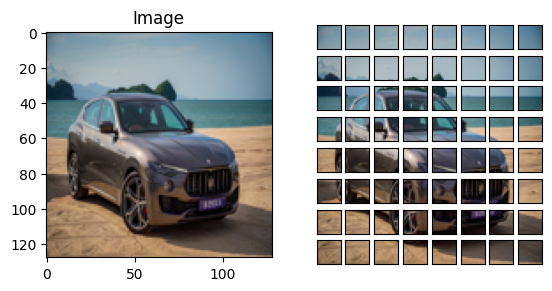

In [37]:
# visualize data
#
# display image and patches side-by-side

fig = plt.figure()

gridspec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gridspec[0])
ax1.set(title='Image')

# display image
ax1.imshow(x)

subgridspec = gridspec[1].subgridspec(8, 8, hspace=-0.8)

# display patches
for i in range(8):    # N = 64, 8x8 grid
    for j in range(8):
        num = i * 8 + j
        ax = fig.add_subplot(subgridspec[i, j])
        ax.set(xticks=[], yticks=[])
        ax.imshow(patches[num])

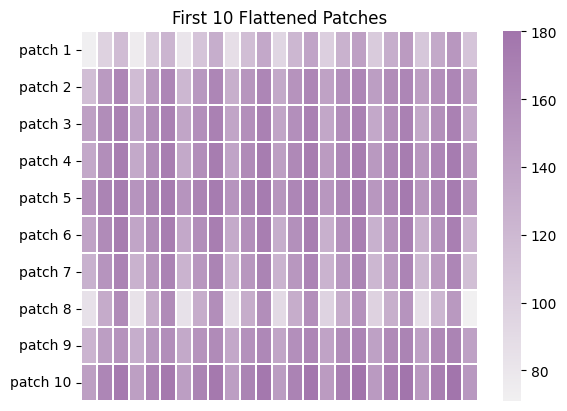

In [38]:
# visualize data
#
# display flattened patches

# display first 10 flattened patches up to 25 values
heat_map = x_p[:10, :25]

yticklabels = ['patch ' + str(i + 1) for i in range(10)]

plt.title('First 10 Flattened Patches')
ax = sns.heatmap(heat_map,
                 cmap=sns.light_palette("#a275ac", as_cmap=True),
                 xticklabels=False, yticklabels=yticklabels,
                 linewidths=0.01, linecolor='white'
                )


## Embedding Patches

<img src='https://raw.githubusercontent.com/IVUL-KAUST/TahakomTraining/main/figs/img3.png' width=80% height=80% />

The Transformer uses constant latent vector size D through all of its layers, so we flatten the patches and map to D dimensions with a trainable linear projection. We refer to the output of this projection as the **patch embeddings**.

In [39]:
# Unit test on patch embeddings

# dimensionality of patch embeddings
D = None

# batch size
B = 1

# convert flattened patches to tensor
x_p = torch.Tensor(x_p)

# add batch dimension
x_p = x_p[None, ...]

# weight matrix E
E = None # nn.Parameter ...

patch_embeddings = None 

assert patch_embeddings.shape == (B, N, D)
print(patch_embeddings.shape)

torch.Size([1, 64, 768])


## Class Token

<img src='https://raw.githubusercontent.com/IVUL-KAUST/TahakomTraining/main/figs/img4.png' width=55% height=55%/>

In order to perform classification, we use the standard approach of adding an extra learnable “classification token” to the sequence.

We prepend a learnable embedding to the sequence of embedded patches (xclass).

In [40]:
# Unit test on class token

# init class token
class_token = None # nn.Parameter

patch_embeddings = torch.cat((None, None), 1) 

print(patch_embeddings.shape)
assert patch_embeddings.shape == (B, N + 1, D)

torch.Size([1, 65, 768])


## Position Embedding
<img src='https://raw.githubusercontent.com/IVUL-KAUST/TahakomTraining/main/figs/img5.png' width=60% height=60%/>

Position embeddings are added to the patch embeddings to **retain positional information**. We use standard learnable 1D position embeddings.
    
Question: Why learn position embedding instead of using Sinusoidal functions?

In [41]:
# Unit test on position embedddings

# position embeddings
E_pos = None # nn.Parameter

z0 = None

print(z0.shape)
assert z0.shape == (B, N + 1, D)

torch.Size([1, 65, 768])


## Self-Attention

<img src='https://raw.githubusercontent.com/IVUL-KAUST/TahakomTraining/main/figs/img6.png'/>

In [42]:
class SelfAttention(nn.Module):
    def __init__(self, embedding_dim=768, key_dim=64):
        super(SelfAttention, self).__init__()

        self.embedding_dim = embedding_dim   # D -> embedding dimensionaltiy
        self.key_dim = key_dim               # D_h -> key, query, value dimensionality

        # U_kqv weight matrix
        self.W = nn.Parameter(torch.randn(embedding_dim, 3*key_dim))

    def forward(self, x):
        key_dim = self.key_dim

        # get query, key and value projection
        qkv = torch.matmul(x, self.W)

        # get query, key, value
        q = qkv[:, :, :key_dim]
        k = qkv[:, :, key_dim:key_dim*2 ]
        v = qkv[:, :, key_dim*2:]

        # compute dot product of the all query with all keys
        k_T = torch.transpose(k, -2, -1)   # get transpose of key
        dot_products = torch.matmul(q, k_T)

        # divide each by √Dh
        scaled_dot_products = dot_products / np.sqrt(key_dim)

        # apply a softmax function to obtain attention weights -> A
        attention_weights = F.softmax(scaled_dot_products, dim=1)

        # get weighted values
        weighted_values = torch.matmul(attention_weights, v)

        # return weighted_values
        return weighted_values

In [43]:
# Unit test on self-attention

# dimensionality of key, query and value
D_h = 64

# init self-attention
self_attention = SelfAttention(D, D_h)   # embedding_dim, key_dim

attention_scores = self_attention(patch_embeddings)

print(attention_scores.shape)
assert attention_scores.shape == (B, N + 1, D_h)

torch.Size([1, 65, 64])


## Multi-Head Self-Attention

<img src='https://raw.githubusercontent.com/IVUL-KAUST/TahakomTraining/main/figs/img7.png'/>

In [44]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12):
        super(MultiHeadSelfAttention, self).__init__()

        self.num_heads = num_heads            # set number of heads (k)
        self.embedding_dim = embedding_dim    # set dimensionality

        assert embedding_dim % num_heads == 0   # dimensionality should be divisible by number of heads
        self.key_dim = embedding_dim // n_head   # set key,query and value dimensionality

        # init self-attentions
        self.attention_list = [SelfAttention(embedding_dim, self.key_dim) for _ in range(num_heads)]
        self.multi_head_attention = nn.ModuleList(self.attention_list)

        # init U_msa weight matrix
        self.W = None # nn.Parameter

    def forward(self, x):
        # compute self-attention scores of each head
        attention_scores = [attention(x) for attention in self.multi_head_attention]

        # concat attentions
        Z = torch.cat(attention_scores, -1)

        # compute multi-head attention score
        attention_score = torch.matmul(Z, self.W)

        return attention_score


In [45]:
# Unit test on multi-head self-attention

# number of heads (k)
n_head = 12

# init multi-head self-attention
multi_head_attention = MultiHeadSelfAttention(D, n_head)

# compute MSA score
attention_score = multi_head_attention(patch_embeddings)

print(attention_score.shape)
assert attention_score.shape == (B, N + 1, D)

torch.Size([1, 65, 768])


## Multi-Layer Perceptron

<img src='https://raw.githubusercontent.com/IVUL-KAUST/TahakomTraining/main/figs/img8.png' width=80% height=80%/>

The MLP contains two layers with a GELU non-linearity.

In [46]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, embedding_dim=768, hidden_dim=3072):
        super(MultiLayerPerceptron, self).__init__()

        self.mlp = nn.Sequential(
                            nn.Linear(embedding_dim, hidden_dim),
                            nn.GELU(),
                            nn.Linear(hidden_dim, embedding_dim)
                   )

    def forward(self, x):
        # pass through multi-layer perceptron
        x = self.mlp(x)
        return x

In [47]:
# Unit test on multi-layer perceptron

# hidden layer dimensionality
hidden_dim = 3072

# init mlp
mlp = MultiLayerPerceptron(D, hidden_dim)

# compute mlp output
output = mlp(patch_embeddings)

assert output.shape == (B, N + 1, D)
output.shape

torch.Size([1, 65, 768])

## Transformer Encoder

<img src='https://raw.githubusercontent.com/IVUL-KAUST/TahakomTraining/main/figs/img9.png'/>

The Transformer encoder consists of alternating layers of multiheaded self-attention (MSA) and MLP blocks. Layernorm (LN) is applied before every block, and residual connections after every block.

In [48]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12, hidden_dim=3072, dropout_prob=0.1):
        super(TransformerEncoder, self).__init__()

        self.MSA = MultiHeadSelfAttention(embedding_dim, num_heads)
        self.MLP = MultiLayerPerceptron(embedding_dim, hidden_dim)

        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.dropout3 = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        # apply dropout
        out_1 = self.dropout1(x)
        # apply layer normalization
        out_2 = self.layer_norm1(out_1)
        # compute multi-head self-attention
        msa_out = self.MSA(out_2)
        # apply dropout
        out_3 = self.dropout2(msa_out)
        # apply residual connection
        res_out = x + out_3
        # apply layer normalization
        out_4 = self.layer_norm2(res_out)
        # compute mlp output
        mlp_out = self.MLP(out_4)
        # apply dropout
        out_5 = self.dropout3(mlp_out)
        # apply residual connection
        output = res_out + out_5

        return output

In [49]:
# Unit test on transformer encoder

# dropout probability
dropout_prob = 0.1

# init transformer encoder
transformer_encoder = TransformerEncoder(D, n_head, hidden_dim, dropout_prob)

# compute transformer encoder output
output = transformer_encoder(patch_embeddings)

assert output.shape == (B, N + 1, D)
output.shape

torch.Size([1, 65, 768])

<img src='https://raw.githubusercontent.com/IVUL-KAUST/TahakomTraining/main/figs/img10.png' width=60% height=60%/>

We found strong regularization to be key when training models from scratch on ImageNet. Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional to patch embeddings.

## MLP Head

<img src='https://raw.githubusercontent.com/IVUL-KAUST/TahakomTraining/main/figs/img11.png'/>

The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

In order to stay as close as possible to the original Transformer model, we made use of an additional [class] token, which is taken as image representation. The output of this token is then transformed into a class prediction via a small multi-layer perceptron (MLP) with tanh as non-linearity in the single hidden layer.

In [50]:
class MLPHead(nn.Module):
    def __init__(self, embedding_dim=768, num_classes=10, fine_tune=False):
        super(MLPHead, self).__init__()
        self.num_classes = num_classes

        if not fine_tune:
            # hidden layer with tanh activation function
            self.mlp_head = nn.Sequential(
                                    nn.Linear(embedding_dim, 3072),  # hidden layer
                                    nn.Tanh(),
                                    nn.Linear(3072, num_classes)    # output layer
                            )
        else:
            # single linear layer
            self.mlp_head = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.mlp_head(x)
        return x


In [51]:
# Unit test on classification head


# extract [class] token from transformer encoder output
z_L = output[0][0]   # extract batch and [class] token

# init number of classes
n_class = 10

# init classification head for pre-training phase
mlp_head_pretrain = MLPHead(D, n_class)
# init classification head for fine-tuning phase
mlp_head_finetune = MLPHead(D, n_class, fine_tune=True)

# compute mlp head output
output_1 = mlp_head_pretrain(z_L)
# compute mlp head output for fine-tuning
output_2 = mlp_head_finetune(z_L)

# size of output
print(output_1.size(dim=0))

# assert output is consistent with number of classes
assert output_1.size(dim=0) == n_class
assert output_2.size(dim=0) == n_class

10


# Build Vision Transformer

<img src='https://raw.githubusercontent.com/IVUL-KAUST/TahakomTraining/main/figs/img12.png'/>

We split an image into fixed-size patches, linearly embed each of them, add position embeddings, and feed the resulting sequence of vectors to a standard Transformer encoder. <br><sub>Model Overview<sub>

<img src='https://raw.githubusercontent.com/IVUL-KAUST/TahakomTraining/main/figs/img13.png'/>

The output of the Transformer encoder (zL0) serves as the image representation y. Both during pre-training and fine-tuning, a classification head is attached to zL0. <br><sub>3.1 Vision Transformer (ViT)<sub>


In [52]:
class VisionTransformer(nn.Module):
    def __init__(self, patch_size=16, image_size=224, channel_size=3,
                     num_layers=12, embedding_dim=768, num_heads=12, hidden_dim=3072,
                            dropout_prob=0.1, num_classes=10, pretrain=True):
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.channel_size = channel_size
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.dropout_prob = dropout_prob
        self.num_classes = num_classes

        # get number of patches of the image
        self.num_patches = int(image_size ** 2 / patch_size ** 2)   # height * width / patch size ^ 2

        # trainable linear projection for mapping dimension of patches (weight matrix E)
        self.W = nn.Parameter(
                    torch.randn( patch_size * patch_size * channel_size, embedding_dim))

        # position embeddings (E_pos)
        self.pos_embedding = nn.Parameter(torch.randn(self.num_patches + 1, embedding_dim))

        # learnable class token embedding (x_class)
        self.class_token = nn.Parameter(torch.rand(1, D))

        # stack transformer encoder layers
        transformer_encoder_list = [
            TransformerEncoder(embedding_dim, num_heads, hidden_dim, dropout_prob)
                    for _ in range(num_layers)]
        self.transformer_encoder_layers = nn.Sequential(*transformer_encoder_list)

        # mlp head
        self.mlp_head = MLPHead(embedding_dim, num_classes)

    def forward(self, x):
        # get patch size and channel size
        P, C = self.patch_size, self.channel_size

        # split image into patches
        patches = x.unfold(1, C, C).unfold(2, P, P).unfold(3, P, P)
        patches = patches.contiguous().view(patches.size(0), -1, C * P * P).float()

        # linearly embed patches
        patch_embeddings = torch.matmul(patches , self.W)

        # add class token
        batch_size = patch_embeddings.shape[0]
        patch_embeddings = torch.cat((self.class_token.repeat(batch_size, 1, 1), patch_embeddings), 1)

        # add positional embedding
        patch_embeddings = patch_embeddings + self.pos_embedding

        # feed patch embeddings into a stack of Transformer encoders
        transformer_encoder_output = self.transformer_encoder_layers(patch_embeddings)

        # extract [class] token from encoder output
        output_class_token = transformer_encoder_output[:, 0]

        # pass token through mlp head for classification
        y = self.mlp_head(output_class_token)

        return y

In [53]:
# Unit test on vision transformer

image_size = 224; channel_size = 3

# number of classes CIFAR-10
n_class = 10

# dropout probability
dropout_prob = 0.1

# Vit-base model configurations
n_layer = 12; embedding_dim = 768; n_head = 12; hidden_dim=3072

# read and resize image
image = Image.open('car.png').resize((image_size, image_size))

# convert PIL image to tensor
X = T.PILToTensor()(image)

# add batch dimension
X =  X[None, ...]    # batch size = 1

# An Image Is Worth 16x16 Words
patch_size = 16

# init vision transformer model
vision_transformer = VisionTransformer(patch_size, image_size, channel_size,
                            n_layer, embedding_dim, n_head, hidden_dim, dropout_prob, n_class)

# compute vision transformer output
vit_output = vision_transformer(X)

assert vit_output.size(dim=1) == n_class
print(vit_output.shape)

# get class probabilities
probabilities = F.softmax(vit_output[0], dim=0)

# probabilities should sum up to 1
print(torch.sum(probabilities))

torch.Size([1, 10])
tensor(1.0000, grad_fn=<SumBackward0>)


# <s>Training</s> Finetuning a Vision Transformer

We seek to have a look at how transformer performs by training the model. However, we are not able to use the configurations that are set for training in the paper since we do not have enough resources :)) Instead, we use different set of hyperparameters for batch size, learning rate, etc. to see the model performance. <br><br>

After several failing attempts and discouraging results, we decide not to train the model implemented here from scratch. To see how model performs, we will use the pytorch [Vision Transformer](https://pytorch.org/vision/main/models/vision_transformer.html) model with pre-trained weights using [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

>We train all models, including ResNets, using Adam with β1 = 0.9, β2 = 0.999, a batch size of 4096 and apply a high weight decay of 0.1, which we found to be useful for transfer of all models. <br><sub>4.1 Setup **Training & Fine-tuning**<sub>

>To boost the performance on the smaller datasets, we optimize three basic regularization parameters – weight decay, dropout, and label smoothing. <br><sub>4.3 Pre-Training Data Requirement<sub>

In [54]:
import torchvision
from torchvision import datasets

In [55]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [56]:
import torchvision.models as models

In [57]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [58]:
# Load data
#
# We will use a subset of CIFAR10 dataset

image_size = 224

# define transform
transform = T.Compose([ T.Resize(image_size), T.ToTensor() ])

torchvision.datasets.CIFAR10.url="http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

# init CIFAR10 training and test datasets
trainset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# get class names
classes = trainset.classes

# get a subset of the trainset and test set
trainset = torch.utils.data.Subset(trainset, list(range(5000)))
testset = torch.utils.data.Subset(testset, list(range(1000)))

# output classes
classes

100%|██████████| 170498071/170498071 [00:03<00:00, 46408277.50it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [59]:
# define data loaders

batch_size = 16

# percentage of training set to use as validation
valid_size = 0.2

# get training indices that wil be used for validation
train_size = len(trainset)
indices = list(range(train_size))
np.random.shuffle(indices)
split = int(np.floor(valid_size * train_size))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers to obtain training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(testset, batch_size=batch_size)

In [60]:
# print out classes statistics

# get all training samples labels
train_labels = [labels for i, (images, labels) in enumerate(train_loader)]
train_labels = torch.cat((train_labels), 0)
train_labels_count = train_labels.unique(return_counts=True)

# print(train_labels_count)

print('The number of samples per classes in training dataset:\n')
for label, count in zip(train_labels_count[0], train_labels_count[1]):
    print('\t {}: {}'.format(label, count))

# get all test samples labels
test_labels = [labels for i, (images, labels) in enumerate(test_loader)]
test_labels = torch.cat((test_labels), 0)
test_labels_count = test_labels.unique(return_counts=True)

print()
print('The number of samples per classes in test dataset:\n')
for label, count in zip(test_labels_count[0], test_labels_count[1]):
    print('\t {}: {}'.format(label, count))

The number of samples per classes in training dataset:

	 0: 407
	 1: 364
	 2: 411
	 3: 404
	 4: 412
	 5: 384
	 6: 409
	 7: 387
	 8: 417
	 9: 405

The number of samples per classes in test dataset:

	 0: 103
	 1: 89
	 2: 100
	 3: 103
	 4: 90
	 5: 86
	 6: 112
	 7: 102
	 8: 106
	 9: 109


In [61]:
# define model

vision_transformer = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

vision_transformer

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 87.9MB/s] 


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [63]:
# vit-16 model is trained on ImageNet
# we expect to have output of 1000 number of classes

vision_transformer.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [64]:
# Fine-tune with dataset

# change the number of output classes
vision_transformer.heads = nn.Linear(in_features=768, out_features=len(classes), bias=True)

# freeze the parameters except the last linear layer
#
# freeze weights
for p in vision_transformer.parameters():
    p.requires_grad = False

# unfreeze weights of classification head to train
for p in vision_transformer.heads.parameters():
    p.requires_grad = True

In [65]:
# Check whether corresponding layers are frozen

for layer_name, p in vision_transformer.named_parameters():
    print('Layer Name: {}, Frozen: {}'.format(layer_name, not p.requires_grad))
    print()

Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.mlp.0.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.mlp.0.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.mlp.3.weight, Fro

In [66]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
# only train the parameters with requires_grad set to True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.0001)


In [67]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

In [69]:
from tqdm import tqdm
# Train model

# number of epochs
n_epoch = 10

train_loss_list, valid_loss_list = [], []

# move model to GPU
if train_on_gpu:
    vision_transformer.to('cuda')

# prepare model for training
vision_transformer.train()

for e in range(n_epoch):
    train_loss = 0.0
    valid_loss = 0.0

    # get batch data
    for i, (images, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):

        # move to gpu if available
        if train_on_gpu:
            images, targets = images.to('cuda'), targets.to('cuda')

        # clear grad
        optimizer.zero_grad()

        # feedforward data
        outputs = vision_transformer(images)

        # calculate loss
        loss = criterion(outputs, targets)

        # backward pass, calculate gradients
        loss.backward()

        # update weights
        optimizer.step()

        # track loss
        train_loss += loss.item()

    # set model to evaluation mode
    vision_transformer.eval()

    # validate model
    for images, targets in valid_loader:

        # move to gpu if available
        if train_on_gpu:
            images = images.to('cuda')
            targets = targets.to('cuda')

        # turn off gradients
        with torch.no_grad():

            outputs = vision_transformer(images)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    # set model back to training mode
    vision_transformer.train()

    # get average loss values
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # output training statistics for epoch
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                  .format( (e+1), train_loss, valid_loss))



100%|██████████| 250/250 [00:45<00:00,  5.44it/s]


Epoch: 1 	 Training Loss: 1.116430 	 Validation Loss: 0.896846


100%|██████████| 250/250 [00:46<00:00,  5.43it/s]


Epoch: 2 	 Training Loss: 0.739805 	 Validation Loss: 0.669870


100%|██████████| 250/250 [00:46<00:00,  5.43it/s]


Epoch: 3 	 Training Loss: 0.582673 	 Validation Loss: 0.568385


100%|██████████| 250/250 [00:45<00:00,  5.44it/s]


Epoch: 4 	 Training Loss: 0.498602 	 Validation Loss: 0.502380


100%|██████████| 250/250 [00:45<00:00,  5.44it/s]


Epoch: 5 	 Training Loss: 0.444729 	 Validation Loss: 0.457784


100%|██████████| 250/250 [00:45<00:00,  5.45it/s]


Epoch: 6 	 Training Loss: 0.407441 	 Validation Loss: 0.435708


100%|██████████| 250/250 [00:45<00:00,  5.46it/s]


Epoch: 7 	 Training Loss: 0.378883 	 Validation Loss: 0.405653


100%|██████████| 250/250 [00:45<00:00,  5.46it/s]


Epoch: 8 	 Training Loss: 0.356038 	 Validation Loss: 0.392488


100%|██████████| 250/250 [00:45<00:00,  5.45it/s]


Epoch: 9 	 Training Loss: 0.337206 	 Validation Loss: 0.376275


100%|██████████| 250/250 [00:45<00:00,  5.44it/s]


Epoch: 10 	 Training Loss: 0.321223 	 Validation Loss: 0.365843


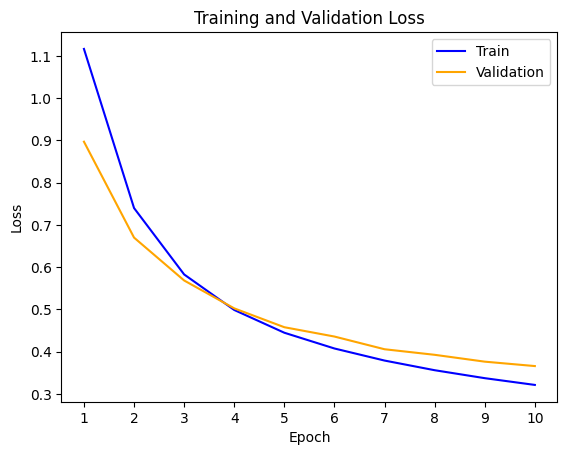

In [70]:
# visualize loss statistics

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# plot losses
x = list(range(1, n_epoch + 1))
plt.plot(x, train_loss_list, color ="blue", label='Train')
plt.plot(x, valid_loss_list, color="orange", label='Validation')
plt.legend(loc="upper right")
plt.xticks(x)

plt.show()

In [ ]:
# prepare model for evaluation
vision_transformer.eval()

test_loss = 0.0
accuracy = 0

# number of classes
n_class = len(classes)

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# move model back to cpu
vision_transformer = vision_transformer.to('cpu')

# test model
for images, targets in test_loader:

    # get outputs
    outputs = vision_transformer(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        targets = targets.to('cpu')

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))


In [ ]:
class_accuracy = class_correct / class_total

print('Test Accuracy of Classes')
print()

for c in range(n_class):
    print('{}\t: {}% \t ({}/{})'.format(classes[c],
                                int(class_accuracy[c] * 100), int(class_correct[c]), int(class_total[c])) )

print()
print('Test Accuracy of Dataset: \t {}% \t ({}/{})'.format(int(accuracy),
                                                           int(np.sum(class_correct)), int(np.sum(class_total)) ))

Test Accuracy of Classes



airplane	: 89% 	 (92/103)

automobile	: 94% 	 (84/89)

bird	: 84% 	 (84/100)

cat	: 81% 	 (84/103)

deer	: 91% 	 (82/90)

dog	: 87% 	 (75/86)

frog	: 91% 	 (103/112)

horse	: 92% 	 (94/102)

ship	: 96% 	 (102/106)

truck	: 87% 	 (95/109)



Test Accuracy of Dataset: 	 89% 	 (895/1000)


# Visualizations

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# Define transforms for test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ImageNet Labels
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

# Demo Image
!wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

--2024-05-05 20:30:25--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.31.207, 142.251.18.207, 142.250.153.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.31.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: 'ilsvrc2012_wordnet_lemmas.txt.1'

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2024-05-05 20:30:25 (76.2 MB/s) - 'ilsvrc2012_wordnet_lemmas.txt.1' saved [21675/21675]

--2024-05-05 20:30:26--  https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/hirotomusiker/schwert_colab_data_storage/raw/master/images/vit

In [47]:
import torchvision.models as models
# Load back the imagenet weights for visualization
vision_transformer = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
vision_transformer.to(device)
vision_transformer.eval() # We are going to use the model in inference mode
vision_transformer.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

Inference Result:
dome



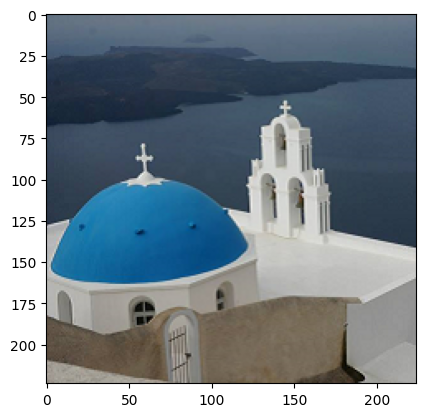

In [48]:
# end-to-end inference
output = vision_transformer(img_tensor)
print("Inference Result:")
print(imagenet_labels[int(torch.argmax(output))])
plt.imshow(img)

## Split image in Patches

The input image is split into N patches (N = 14 x 14 for ViT-Base)
and converted to D=768 embedding vectors by learnable 2D convolution:
```
Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
```

In [6]:
patches = vision_transformer.conv_proj(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)
patches=patches.permute(0, 2, 3, 1)
patches=patches.view(1, -1, 768)
print("Patch embeddings flatten: ", patches.shape)

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 768, 14, 14])
Patch embeddings flatten:  torch.Size([1, 196, 768])


Note that The operation `Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))` is actually more than just splitting the image into patches. It's a critical and learned part of the model that not only segments the image but **also projects each patch directly into a high-dimensional embedding space**. 

In [ ]:
# This is NOT a part of the pipeline.
# Actually the image is divided into patch embeddings by Conv2d 
# with stride=(16, 16) shown above.
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of Patches", fontsize=24)
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

## Position Embedding

In [ ]:
pos_embed = vision_transformer.encoder.pos_embedding
pos_embed.shape

torch.Size([1, 197, 768])

In [ ]:
# Visualize position embedding similarities.
# One cell shows cos similarity between an embedding and all the other embeddings.
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=16)
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

## How Attention Works

In this part, we are going to see what the actual attention looks like.

In [49]:
features=[]
def hook(module, input, output):
    """
    A hook function to capture the output of a specific layer during the forward pass.

    This function is attached to a model layer and is called every time the layer processes input.
    It captures the output of the layer and appends it to a global list `features`.

    Args:
        module (torch.nn.Module): The layer to which this hook is attached.
        input (tuple): The input to the `module`. This is a tuple of tensors representing the inputs to the module.
        output (torch.Tensor): The output from the `module`. This is the tensor produced by the module as output.

    """
    # This is where the output of the layer is captured and appended to the global list `features`.
    features.append(output)

# Attach the hook to the layer of interest
# Since we want to see the visualization of the last layer in the encoder (layer 11) we will attach it to the hook
#The last component generating features for the the self-attention in encoder layer 11 is ln_1 (LayerNormalization), so we extract the features from
handle = vision_transformer.encoder.layers.encoder_layer_0.ln_1.register_forward_hook(hook)
vision_transformer.eval()

# Pass the image through the model at the inference mode
with torch.no_grad():
    outputs = vision_transformer(img_tensor)
handle.remove()

In [50]:
# Pass the image through the model
m = vision_transformer
with torch.no_grad():
    # We get the output
    output = m(img_tensor)
    # print(output.shape)

    # So here we get the weights and biases for the quer, key, and value
    qkv_w = m.encoder.layers.encoder_layer_11.self_attention.in_proj_weight
    qkv_b = m.encoder.layers.encoder_layer_11.self_attention.in_proj_bias

    print(f"The shape of qkv weight matrix before reshaping is {qkv_w.shape}\n")
    print(f"The shape of qkv bias matrix before reshaping is {qkv_b.shape}\n")
    # print(qkv_w.shape)
    """we have shape of (2304 * 768), we need to understand what is the meaning of the dimensions we have?
    first of all, the 768 represents the D-hidden dimension through the encoder of the vision transformer which is fiexd across all of the encoder network.
    2304 is a little bit tricky and you need to check the original paper to understand why the shape looks like that.

    We have 3 components (query, keys, and values) for each head, and at the encoder (Architecture dependent) we have 12 heads, then we explore this as first divide 2304 by 12 to get dimensions for each head = 2304/12 = 192, here remember that we have 3 matrices stacked so 192/3 = 64, 
    which is the dimension of the head mentioned in the paper as D_{h} = D/k, and K is the number of heads which is 12 for the vit_b_16()"""

    #shape here is (matrices, d_head *k, d_hidden)
    qkv_w = qkv_w.reshape(3, -1, 768)
    qkv_b = qkv_b.reshape(12, -1, 64)

    print(f"The shape of qkv weight matrix after reshaping is {qkv_w.shape}\n")
    print(f"The shape of qkv bias matrix after reshaping is {qkv_b.shape}\n")

    "Here we get the weights and biases for each component for all of the heads"
    
    #shape here for each weight component is (d_head *k, d_hidden)
    q_w_12_heads = qkv_w[0,:,:]
    k_w_12_heads = qkv_w[1,:,:]
    v_w_12_heads = qkv_w[2,:,:]

    
    q_b_12_heads = qkv_b[:,0,:]
    k_b_12_heads = qkv_b[:,1,:]
    v_b_12_heads = qkv_b[:,2,:]


    print(f"The shape of query weight matrix before reshaping is {q_w_12_heads.shape}, key weight is {k_w_12_heads.shape}, and values weight is {v_w_12_heads.shape}\n")
    print(f"The shape of query bias matrix before reshaping is {q_b_12_heads.shape}, key bias is {k_b_12_heads.shape}, and values bias is {v_b_12_heads.shape}\n")

    # Shape here is (no.head, d_head, d_hidden)
    q_w_12_heads = q_w_12_heads.reshape(12, -1, 768)
    k_w_12_heads = k_w_12_heads.reshape(12, -1, 768)
    v_w_12_heads = v_w_12_heads.reshape(12, -1, 768)


    
    print(f"The shape of query weight matrix after reshaping is {q_w_12_heads.shape}, key weight is {k_w_12_heads.shape}, and values weight is {v_w_12_heads.shape}\n")
    # Shape here for each weight component is(d_head, d_hidden)
    q_w_1_head = q_w_12_heads[0,:,:]
    k_w_1_head = k_w_12_heads[0,:,:]
    v_w_1_head = v_w_12_heads[0,:,:]

    q_b_1_head = q_b_12_heads[0,:]
    k_b_1_head = k_b_12_heads[0,:]
    v_b_1_head = v_b_12_heads[0,:]

    print(f"The shape of query weight matrix after reshaping for one head is {q_w_1_head.shape}, key weight is {k_w_1_head .shape}, and values weight is {v_w_1_head .shape}\n")
    print(f"The shape of query bias matrix after reshaping for one head is {q_b_1_head.shape}, key bias is {k_b_1_head .shape}, and values bias is {v_b_1_head .shape}\n")


    out_encoder_10 = features[0][0]
    out_encoder_10 = out_encoder_10.unsqueeze(0)
    # print(out_encoder_10.shape)


    # place holder to get the attention weights from the heads to use it for later calculations
    att_weights =[]
    satt = []

    # This loop is created to loop over the heads, in order to get all of the attention matrices (qk^{T}) per heads
    for i in range(12):
        q_w = q_w_12_heads[i,:,:]
        k_w = k_w_12_heads[i,:,:]
        v_w = v_w_12_heads[i,:,:]

        q_b = q_b_12_heads[i,:]
        k_b = k_b_12_heads[i,:]
        v_b = v_b_12_heads[i,:]

        

        q = torch.matmul(out_encoder_10, q_w.T) 
        k = torch.matmul(out_encoder_10, k_w.T) 
        v = torch.matmul(out_encoder_10, v_w.T) 

        qk = torch.matmul(q, k.transpose(2, 1))/8
        qk = torch.softmax(qk, dim=(2))
        # print(qk.shape)
        att_weights.append(qk)

The shape of qkv weight matrix before reshaping is torch.Size([2304, 768])

The shape of qkv bias matrix before reshaping is torch.Size([2304])

The shape of qkv weight matrix after reshaping is torch.Size([3, 768, 768])

The shape of qkv bias matrix after reshaping is torch.Size([12, 3, 64])

The shape of query weight matrix before reshaping is torch.Size([768, 768]), key weight is torch.Size([768, 768]), and values weight is torch.Size([768, 768])

The shape of query bias matrix before reshaping is torch.Size([12, 64]), key bias is torch.Size([12, 64]), and values bias is torch.Size([12, 64])

The shape of query weight matrix after reshaping is torch.Size([12, 64, 768]), key weight is torch.Size([12, 64, 768]), and values weight is torch.Size([12, 64, 768])

The shape of query weight matrix after reshaping for one head is torch.Size([64, 768]), key weight is torch.Size([64, 768]), and values weight is torch.Size([64, 768])

The shape of query bias matrix after reshaping for one head 

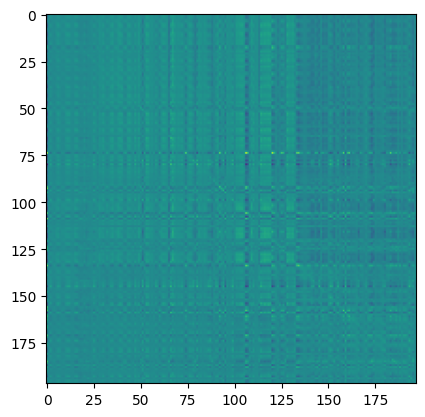

(<matplotlib.image.AxesImage at 0x7f53d6018be0>, None)

In [38]:
plt.imshow(att_weights[3][0].detach().cpu().numpy()), plt.show()

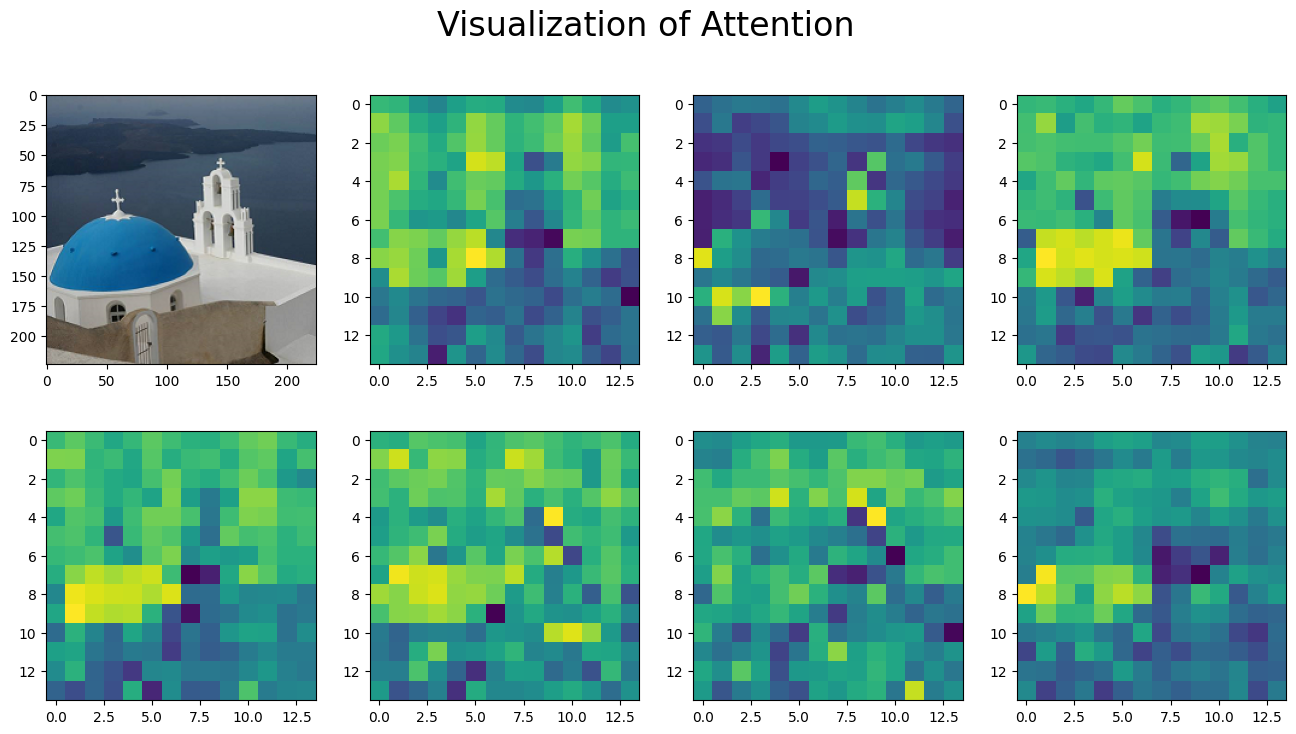

In [59]:
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention", fontsize=24)
# fig.add_axes()
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = att_weights[i][0][100, 1:].reshape((14, 14)).detach().cpu().numpy()
    attn_heatmap = attn_heatmap/attn_heatmap.max()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

**Final Notes**

The implementation here is a very basic representation of how Vision Transformers work. The code structure here is to preserve the simplicity of the code so that to be easier to follow. There are a lot of improvements that can be made in the implementation and calculations can be further optimized.

---

### Resources

1.  An Image is Worth 16x16 Words: Transformers For Image Recognition At Scale Paper - https://arxiv.org/pdf/2010.11929.pdf
2. Illustrated Transformer Blog Post - https://jalammar.github.io/illustrated-transformer/
3. Attention is All You Need Paper - https://arxiv.org/pdf/1706.03762.pdf
4. What exactly are keys, queries, and values in attention mechanisms? - https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms

### Acknowledgment
We thank the author of https://github.com/nerminnuraydogan/vision-transformer for the great notebook containing a walk-through of the Vision Transformer model with illustrations.